In [7]:
using AutomotiveDrivingModels
using AutoViz
using AutomotiveSensors
using AutomotivePOMDPs
using Parameters
using Reel
using StaticArrays
using ProfileView

using GridInterpolations 
using POMDPs
using POMDPToolbox
using QMDP
using JLD

using Revise


include("../src/pedestrian_crossing/pomdp_types.jl")
include("../src/pedestrian_crossing/spaces.jl")
include("../src/pedestrian_crossing/transition.jl")
include("../src/pedestrian_crossing/observation.jl")
include("../src/pedestrian_crossing/belief.jl")



include("../src/pedestrian_crossing/frenet_pedestrian_pomdp.jl")


LoadError: LoadError: [91minvalid redefinition of constant SingleOCFPOMDP[39m
while loading /home/xubuntu/stanford/AutomotivePOMDPs/src/pedestrian_crossing/pomdp_types.jl, in expression starting on line 558

ERROR (unhandled task failure): InterruptException:
Stacktrace:
 [1] process_events at ./libuv.jl:82 [inlined]
 [2] wait() at ./event.jl:216
 [3] wait(::Condition) at ./event.jl:27
 [4] stream_wait(::Timer, ::Condition, ::Vararg{Condition,N} where N) at ./stream.jl:42
 [5] wait(::Timer) at ./event.jl:357
 [6] (::Base.##302#303{IJulia.#send_stderr,Timer})() at ./event.jl:430


In [2]:
function AutomotiveDrivingModels.observe!(model::FrenetPedestrianPOMDP, scene::Scene, roadway::Roadway, egoid::Int)

    ego = scene[findfirst(scene, egoid)]
    model.ego_vehicle = ego
    model.sensor_observations = measure(model.sensor, ego, scene, roadway, model.obstacles)
    

    ################ High Level Planner ###################################################
    if (  true ) #model.tick % model.update_tick_high_level_planner == 0 )


        println("--------------------------POMDP high level planner----------------------- t: ", model.t_current)
        println("EGO: x/y:", ego.state.posG.x, " / ",  ego.state.posG.y, " v: ", ego.state.v)

        ego_t = ego.state.posF.t
        ego_s = ego.state.posF.s
        ego_v = ego.state.v
        obs = pomdp.state_space[end]   
        obs_int = pomdp.state_space[end]   

        delta_s = -10.
        delta_t = -10.
        for object in model.sensor_observations
            println("PED: x/y: ", object.state.posG.x, " / ", object.state.posG.y, " v: ", object.state.v)
            
            object_posF = Frenet(proj(object.state.posG, get_lane(env.roadway, ego.state), env.roadway, move_along_curves=false),env.roadway)
            
            delta_s = object_posF.s - ego_s
            delta_t = object_posF.t - ego_t
            delta_theta = object_posF.ϕ - ego.state.posF.ϕ
            ped_v = object.state.v
            
            obs = SingleOCFState(ego_t, ego_v, delta_s, delta_t, delta_theta, ped_v)
            obs_int = model.pomdp.state_space[state_index(pomdp,obs )]
            println("delta_s: ", delta_s, " delta_t: ", delta_t)
            println("Observation cont: ", obs)
            println("Observation disc: ", obs_int)           

        end
        
        pomdp.ego_vehicle = ego
        pomdp.obstacles = model.obstacles


                
        # init belief
        if (model.t_current == 0 )
            # no object or out of state space
            if ( length(model.sensor_observations) == 0 || (delta_s > pomdp.S_MAX || delta_s < pomdp.S_MIN || delta_t > pomdp.T_MAX || delta_t < pomdp.T_MIN) )
                model.b = initBeliefAbsentPedestrian(pomdp, ego_t, ego_v)
                println("init belief absent")
            else
                model.b = initBeliefPedestrian(pomdp, obs)
                #model.b = initBeliefAbsentPedestrian(pomdp, ego_t, ego_v)
                println("init belief observation")

            end
        else

#=    
            ## debug

            if ( length(model.sensor_observations) == 0 || (delta_s > pomdp.S_MAX || delta_s < pomdp.S_MIN || delta_t > pomdp.T_MAX || delta_t < pomdp.T_MIN) )
                model.b = initBeliefAbsentPedestrian(pomdp, ego_y, ego_v)
            else
                model.b = initBeliefPedestrian(pomdp, obs)
            end

            ## end debug 
=#
            action_pomdp = SingleOCFAction(model.a.a_lon, model.a.a_lat)
            println("action before update: ", action_pomdp)

            b_ = update(model.updater, model.b, action_pomdp, obs)  
            model.b = deepcopy(b_)
         #   println(model.b)
            println("b-length: ", length(model.b))
            
            act = action(model.policy, model.b) # policy
            #model.a = LatLonAccel(act.lateral_movement, act.acc)
            println("action after update: ", act)

            if (model.tick > 6 )
                model.a = LatLonAccel(0.0, -2.0)
                println("manual intervention")
                println(model.b)
            end

        end


    end
    
    model.risk = length(model.b)

    model.tick += 1
    model.t_current = model.t_current + model.timestep 

end


In [3]:
include("../src/pedestrian_crossing/pomdp_types.jl")
include("../src/pedestrian_crossing/spaces.jl")
include("../src/pedestrian_crossing/transition.jl")
include("../src/pedestrian_crossing/observation.jl")
include("../src/pedestrian_crossing/belief.jl")

include("../src/pedestrian_crossing/frenet_pedestrian_pomdp.jl")


qmdp_policy = load("policy.jld")["policy"];


pomdp = SingleOCFPOMDP()
updater = SingleOCFUpdater(pomdp)

params = CrosswalkParams()
params.obstacles_visible = false

obstacle_1 = ConvexPolygon([VecE2(34, -1.5), VecE2(34, -4.5), VecE2(46.5, -4.5), VecE2(46.5, -1.5)],4)
obstacle_2 = ConvexPolygon([VecE2(34, +4.5), VecE2(34, +7.5), VecE2(46.5, +7.5), VecE2(46.5, +4.5)],4)
params.obstacles = [obstacle_1, obstacle_2]
#params.obstacles = [obstacle_2]

env = CrosswalkEnv(params)
pomdp.env = env


ego_v = 10.73
ped_v = 5.4/3.6
hitpoint = 0             # 50: middle, 100: left corner, 0: right corner
ped_theta = π/2


# fix values
ped_x = 50.0
ped_y_start = -4.0
ego_y = 0.0


ped_y_offset_hitpoint = VehicleDef().width * hitpoint / 100 - VehicleDef().width/2
ped_y_end = ped_y_offset_hitpoint
ped_t_collision = (ped_y_end - ped_y_start) / ped_v; 
ego_x = ped_x - ego_v * ped_t_collision - VehicleDef().length/2;

if ( false )
    ego_v = 0.0
    ego_x = 20
    ped_x = 30
    ped_y_start = -2.0
    ped_v = 0.0
end

#ped_y_start = -15.0
ped_v = 0.0

# Car definition
ego_initial_state = VehicleState(VecSE2(ego_x, ego_y, 0.), env.roadway.segments[1].lanes[1], env.roadway, ego_v)
ego = Vehicle(ego_initial_state, VehicleDef(), 1)

# Pedestrian definition using our new Vehicle definition
ped_initial_state = VehicleState(VecSE2(ped_x,ped_y_start,ped_theta), env.crosswalk, env.roadway, ped_v)
ped = Vehicle(ped_initial_state, AutomotivePOMDPs.PEDESTRIAN_DEF, 2)

scene = Scene()
push!(scene, ego)
push!(scene, ped)



cam = FitToContentCamera(0.);
timestep = 0.2


pos_noise = 0.001
vel_noise = 0.001
false_positive_rate = 0.00
false_negative_rate = 0.00
rng = MersenneTwister(1);
sensor = AutomotiveSensors.GaussianSensor(AutomotiveSensors.LinearNoise(10, pos_noise, 0.00), 
                 AutomotiveSensors.LinearNoise(10, vel_noise, 0.00), false_positive_rate, false_negative_rate, rng) 



# define a model for each entities present in the scene
models = Dict{Int, DriverModel}()

ego_id = 1
ped_id = 2

obs = SingleOCFState(0.0, ego_v, ped_x-ego_x, ped_y_start, ped_theta, ped_v)
println(obs)
models[ego_id] = FrenetPedestrianPOMDP(a=LatLonAccel(0.0, 0.0),env=env,sensor=sensor, obstacles=env.obstacles, timestep=timestep,
    env=env,
    pomdp=pomdp,
    policy=qmdp_policy,
    updater=updater,
    ego_vehicle=ego,
    desired_velocity=ego_v,
    b=initBeliefPedestrian(pomdp, obs)
  #  b=initBeliefAbsentPedestrian(pomdp, ego_y, ego_v)
)
models[ego_id].pomdp.desired_velocity = ego_v
models[ego_id].pomdp.ΔT = timestep

models[ped_id] = ConstantPedestrian(v_desired=ped_v, dawdling_amp=0.001) # dumb model

nticks = 20
rec = SceneRecord(nticks+1, timestep)

risk = Float64[]
sensor_observations = [Vehicle[]]
belief = SingleOCFBelief[]
ego_vehicle = Vehicle[]
action_pomdp = SingleOCFAction[]

obs_callback = (ObservationCallback(risk,sensor_observations, belief, ego_vehicle, action_pomdp),)

tic()
simulate!(rec, scene, env.roadway, models, nticks, obs_callback)
toc()




SingleOCFState(0.0, 10.73, 24.175333333333338, -4.0, 1.5707963267948966, 0.0)
--------------------------POMDP high level planner----------------------- t: 0.0
EGO: x/y:25.824666666666662 / 0.0 v: 10.73
PED: x/y: 50.00038239596779 / -4.000597634476728 v: -1.044524463737564e-5
delta_s: 24.175715729301128 delta_t: -4.000597634476728
Observation cont: SingleOCFState(0.0, 10.73, 24.175715729301128, -4.000597634476728, 1.5707963267948966, -1.044524463737564e-5)
Observation disc: SingleOCFState(0.0, 10.5, 24.0, -4.0, 1.57, 0.0)
init belief observation
--------------------------POMDP high level planner----------------------- t: 0.2
EGO: x/y:27.970666666666663 / 0.0 v: 10.73
PED: x/y: 49.99904928505127 / -3.997704912176162 v: -0.0022670863488005307
delta_s: 22.028382618384605 delta_t: -3.997704912176162
Observation cont: SingleOCFState(0.0, 10.73, 22.028382618384605, -3.997704912176162, 1.5707963267948966, -0.0022670863488005307)
Observation disc: SingleOCFState(0.0, 10.5, 22.0, -4.0, 1.57, 0.0

POMDPToolbox.SparseCat{Array{SingleOCFState,1},Array{Float64,1}}(SingleOCFState[SingleOCFState(0.0, 10.5, 8.0, -5.0, 1.57, 0.0), SingleOCFState(0.0, 10.5, 9.0, -5.0, 1.57, 0.0), SingleOCFState(0.0, 10.5, 10.0, -5.0, 1.57, 0.0), SingleOCFState(0.0, 10.5, 11.0, -5.0, 1.57, 0.0), SingleOCFState(0.0, 10.5, 12.0, -5.0, 1.57, 0.0), SingleOCFState(0.0, 10.5, 8.0, -4.5, 1.57, 0.0), SingleOCFState(0.0, 10.5, 9.0, -4.5, 1.57, 0.0), SingleOCFState(0.0, 10.5, 10.0, -4.5, 1.57, 0.0), SingleOCFState(0.0, 10.5, 11.0, -4.5, 1.57, 0.0), SingleOCFState(0.0, 10.5, 12.0, -4.5, 1.57, 0.0), SingleOCFState(0.0, 10.5, 8.0, -4.0, 1.57, 0.0), SingleOCFState(0.0, 10.5, 9.0, -4.0, 1.57, 0.0), SingleOCFState(0.0, 10.5, 10.0, -4.0, 1.57, 0.0), SingleOCFState(0.0, 10.5, 11.0, -4.0, 1.57, 0.0), SingleOCFState(0.0, 10.5, 12.0, -4.0, 1.57, 0.0), SingleOCFState(0.0, 10.5, 8.0, -3.5, 1.57, 0.0), SingleOCFState(0.0, 10.5, 9.0, -3.5, 1.57, 0.0), SingleOCFState(0.0, 10.5, 10.0, -3.5, 1.57, 0.0), SingleOCFState(0.0, 10.5, 11

1.0, 1.57, 2.0), SingleOCFState(0.0, 10.5, 9.0, -1.0, 1.57, 2.0), SingleOCFState(0.0, 10.5, 10.0, -1.0, 1.57, 2.0), SingleOCFState(0.0, 10.5, 11.0, -1.0, 1.57, 2.0), SingleOCFState(0.0, 10.5, 9.0, -0.5, 1.57, 2.0)], [1.38823e-9, 0.000232164, 0.000780658, 9.90596e-8, 7.3722e-17, 9.67366e-8, 0.016178, 0.0543989, 6.90282e-6, 5.13721e-15, 4.61278e-7, 0.0771429, 0.259395, 3.29153e-5, 2.44962e-14, 9.7745e-8, 0.0163466, 0.054966, 6.97478e-6, 5.19076e-15, 1.34957e-9, 0.0002257, 0.000758921, 9.63014e-8, 7.16693e-17, 2.52015e-12, 4.21464e-7, 1.41718e-6, 1.7983e-10, 1.33833e-19, 5.3729e-16, 8.9855e-11, 3.0214e-10, 3.83393e-14, 2.85328e-23, 7.40904e-21, 1.23907e-15, 4.16641e-15, 5.28686e-19, 3.93458e-28, 4.5235e-27, 7.56499e-22, 2.54375e-21, 3.22783e-25, 2.40221e-34, 1.0306e-34, 1.72354e-29, 5.79546e-29, 7.354e-33, 1.46342e-43, 3.14591e-43, 1.00696e-9, 0.000168401, 0.000566254, 7.18534e-8, 5.34746e-17, 7.07297e-8, 0.0118287, 0.0397742, 5.04705e-6, 3.7561e-15, 3.45411e-7, 0.0577656, 0.194239, 2.464

LoadError: [91m  Failed discrete belief update: new probabilities sum to zero.
#  b = POMDPToolbox.SparseCat{Array{SingleOCFState,1},Array{Float64,1}}(SingleOCFState[SingleOCFState(0.0, 10.5, 8.0, -5.0, 1.57, 0.0), SingleOCFState(0.0, 10.5, 9.0, -5.0, 1.57, 0.0), SingleOCFState(0.0, 10.5, 10.0, -5.0, 1.57, 0.0), SingleOCFState(0.0, 10.5, 11.0, -5.0, 1.57, 0.0), SingleOCFState(0.0, 10.5, 12.0, -5.0, 1.57, 0.0), SingleOCFState(0.0, 10.5, 8.0, -4.5, 1.57, 0.0), SingleOCFState(0.0, 10.5, 9.0, -4.5, 1.57, 0.0), SingleOCFState(0.0, 10.5, 10.0, -4.5, 1.57, 0.0), SingleOCFState(0.0, 10.5, 11.0, -4.5, 1.57, 0.0), SingleOCFState(0.0, 10.5, 12.0, -4.5, 1.57, 0.0), SingleOCFState(0.0, 10.5, 8.0, -4.0, 1.57, 0.0), SingleOCFState(0.0, 10.5, 9.0, -4.0, 1.57, 0.0), SingleOCFState(0.0, 10.5, 10.0, -4.0, 1.57, 0.0), SingleOCFState(0.0, 10.5, 11.0, -4.0, 1.57, 0.0), SingleOCFState(0.0, 10.5, 12.0, -4.0, 1.57, 0.0), SingleOCFState(0.0, 10.5, 8.0, -3.5, 1.57, 0.0), SingleOCFState(0.0, 10.5, 9.0, -3.5, 1.57, 0.0), SingleOCFState(0.0, 10.5, 10.0, -3.5, 1.57, 0.0), SingleOCFState(0.0, 10.5, 11.0, -3.5, 1.57, 0.0), SingleOCFState(0.0, 10.5, 12.0, -3.5, 1.57, 0.0), SingleOCFState(0.0, 10.5, 8.0, -3.0, 1.57, 0.0), SingleOCFState(0.0, 10.5, 9.0, -3.0, 1.57, 0.0), SingleOCFState(0.0, 10.5, 10.0, -3.0, 1.57, 0.0), SingleOCFState(0.0, 10.5, 11.0, -3.0, 1.57, 0.0), SingleOCFState(0.0, 10.5, 12.0, -3.0, 1.57, 0.0), SingleOCFState(0.0, 10.5, 8.0, -2.5, 1.57, 0.0), SingleOCFState(0.0, 10.5, 9.0, -2.5, 1.57, 0.0), SingleOCFState(0.0, 10.5, 10.0, -2.5, 1.57, 0.0), SingleOCFState(0.0, 10.5, 11.0, -2.5, 1.57, 0.0), SingleOCFState(0.0, 10.5, 12.0, -2.5, 1.57, 0.0), SingleOCFState(0.0, 10.5, 8.0, -2.0, 1.57, 0.0), SingleOCFState(0.0, 10.5, 9.0, -2.0, 1.57, 0.0), SingleOCFState(0.0, 10.5, 10.0, -2.0, 1.57, 0.0), SingleOCFState(0.0, 10.5, 11.0, -2.0, 1.57, 0.0), SingleOCFState(0.0, 10.5, 12.0, -2.0, 1.57, 0.0), SingleOCFState(0.0, 10.5, 8.0, -1.5, 1.57, 0.0), SingleOCFState(0.0, 10.5, 9.0, -1.5, 1.57, 0.0), SingleOCFState(0.0, 10.5, 10.0, -1.5, 1.57, 0.0), SingleOCFState(0.0, 10.5, 11.0, -1.5, 1.57, 0.0), SingleOCFState(0.0, 10.5, 12.0, -1.5, 1.57, 0.0), SingleOCFState(0.0, 10.5, 8.0, -1.0, 1.57, 0.0), SingleOCFState(0.0, 10.5, 9.0, -1.0, 1.57, 0.0), SingleOCFState(0.0, 10.5, 10.0, -1.0, 1.57, 0.0), SingleOCFState(0.0, 10.5, 11.0, -1.0, 1.57, 0.0), SingleOCFState(0.0, 10.5, 12.0, -1.0, 1.57, 0.0), SingleOCFState(0.0, 10.5, 8.0, -0.5, 1.57, 0.0), SingleOCFState(0.0, 10.5, 9.0, -0.5, 1.57, 0.0), SingleOCFState(0.0, 10.5, 10.0, -0.5, 1.57, 0.0), SingleOCFState(0.0, 10.5, 11.0, -0.5, 1.57, 0.0), SingleOCFState(0.0, 10.5, 9.0, 0.0, 1.57, 0.0), SingleOCFState(0.0, 10.5, 10.0, 0.0, 1.57, 0.0), SingleOCFState(0.0, 10.5, 8.0, -5.0, 1.57, 0.5), SingleOCFState(0.0, 10.5, 9.0, -5.0, 1.57, 0.5), SingleOCFState(0.0, 10.5, 10.0, -5.0, 1.57, 0.5), SingleOCFState(0.0, 10.5, 11.0, -5.0, 1.57, 0.5), SingleOCFState(0.0, 10.5, 12.0, -5.0, 1.57, 0.5), SingleOCFState(0.0, 10.5, 8.0, -4.5, 1.57, 0.5), SingleOCFState(0.0, 10.5, 9.0, -4.5, 1.57, 0.5), SingleOCFState(0.0, 10.5, 10.0, -4.5, 1.57, 0.5), SingleOCFState(0.0, 10.5, 11.0, -4.5, 1.57, 0.5), SingleOCFState(0.0, 10.5, 12.0, -4.5, 1.57, 0.5), SingleOCFState(0.0, 10.5, 8.0, -4.0, 1.57, 0.5), SingleOCFState(0.0, 10.5, 9.0, -4.0, 1.57, 0.5), SingleOCFState(0.0, 10.5, 10.0, -4.0, 1.57, 0.5), SingleOCFState(0.0, 10.5, 11.0, -4.0, 1.57, 0.5), SingleOCFState(0.0, 10.5, 12.0, -4.0, 1.57, 0.5), SingleOCFState(0.0, 10.5, 8.0, -3.5, 1.57, 0.5), SingleOCFState(0.0, 10.5, 9.0, -3.5, 1.57, 0.5), SingleOCFState(0.0, 10.5, 10.0, -3.5, 1.57, 0.5), SingleOCFState(0.0, 10.5, 11.0, -3.5, 1.57, 0.5), SingleOCFState(0.0, 10.5, 12.0, -3.5, 1.57, 0.5), SingleOCFState(0.0, 10.5, 8.0, -3.0, 1.57, 0.5), SingleOCFState(0.0, 10.5, 9.0, -3.0, 1.57, 0.5), SingleOCFState(0.0, 10.5, 10.0, -3.0, 1.57, 0.5), SingleOCFState(0.0, 10.5, 11.0, -3.0, 1.57, 0.5), SingleOCFState(0.0, 10.5, 12.0, -3.0, 1.57, 0.5), SingleOCFState(0.0, 10.5, 8.0, -2.5, 1.57, 0.5), SingleOCFState(0.0, 10.5, 9.0, -2.5, 1.57, 0.5), SingleOCFState(0.0, 10.5, 10.0, -2.5, 1.57, 0.5), SingleOCFState(0.0, 10.5, 11.0, -2.5, 1.57, 0.5), SingleOCFState(0.0, 10.5, 12.0, -2.5, 1.57, 0.5), SingleOCFState(0.0, 10.5, 8.0, -2.0, 1.57, 0.5), SingleOCFState(0.0, 10.5, 9.0, -2.0, 1.57, 0.5), SingleOCFState(0.0, 10.5, 10.0, -2.0, 1.57, 0.5), SingleOCFState(0.0, 10.5, 11.0, -2.0, 1.57, 0.5), SingleOCFState(0.0, 10.5, 12.0, -2.0, 1.57, 0.5), SingleOCFState(0.0, 10.5, 8.0, -1.5, 1.57, 0.5), SingleOCFState(0.0, 10.5, 9.0, -1.5, 1.57, 0.5), SingleOCFState(0.0, 10.5, 10.0, -1.5, 1.57, 0.5), SingleOCFState(0.0, 10.5, 11.0, -1.5, 1.57, 0.5), SingleOCFState(0.0, 10.5, 12.0, -1.5, 1.57, 0.5), SingleOCFState(0.0, 10.5, 8.0, -1.0, 1.57, 0.5), SingleOCFState(0.0, 10.5, 9.0, -1.0, 1.57, 0.5), SingleOCFState(0.0, 10.5, 10.0, -1.0, 1.57, 0.5), SingleOCFState(0.0, 10.5, 11.0, -1.0, 1.57, 0.5), SingleOCFState(0.0, 10.5, 12.0, -1.0, 1.57, 0.5), SingleOCFState(0.0, 10.5, 8.0, -0.5, 1.57, 0.5), SingleOCFState(0.0, 10.5, 9.0, -0.5, 1.57, 0.5), SingleOCFState(0.0, 10.5, 10.0, -0.5, 1.57, 0.5), SingleOCFState(0.0, 10.5, 11.0, -0.5, 1.57, 0.5), SingleOCFState(0.0, 10.5, 9.0, 0.0, 1.57, 0.5), SingleOCFState(0.0, 10.5, 8.0, -5.0, 1.57, 1.0), SingleOCFState(0.0, 10.5, 9.0, -5.0, 1.57, 1.0), SingleOCFState(0.0, 10.5, 10.0, -5.0, 1.57, 1.0), SingleOCFState(0.0, 10.5, 11.0, -5.0, 1.57, 1.0), SingleOCFState(0.0, 10.5, 12.0, -5.0, 1.57, 1.0), SingleOCFState(0.0, 10.5, 8.0, -4.5, 1.57, 1.0), SingleOCFState(0.0, 10.5, 9.0, -4.5, 1.57, 1.0), SingleOCFState(0.0, 10.5, 10.0, -4.5, 1.57, 1.0), SingleOCFState(0.0, 10.5, 11.0, -4.5, 1.57, 1.0), SingleOCFState(0.0, 10.5, 12.0, -4.5, 1.57, 1.0), SingleOCFState(0.0, 10.5, 8.0, -4.0, 1.57, 1.0), SingleOCFState(0.0, 10.5, 9.0, -4.0, 1.57, 1.0), SingleOCFState(0.0, 10.5, 10.0, -4.0, 1.57, 1.0), SingleOCFState(0.0, 10.5, 11.0, -4.0, 1.57, 1.0), SingleOCFState(0.0, 10.5, 12.0, -4.0, 1.57, 1.0), SingleOCFState(0.0, 10.5, 8.0, -3.5, 1.57, 1.0), SingleOCFState(0.0, 10.5, 9.0, -3.5, 1.57, 1.0), SingleOCFState(0.0, 10.5, 10.0, -3.5, 1.57, 1.0), SingleOCFState(0.0, 10.5, 11.0, -3.5, 1.57, 1.0), SingleOCFState(0.0, 10.5, 12.0, -3.5, 1.57, 1.0), SingleOCFState(0.0, 10.5, 8.0, -3.0, 1.57, 1.0), SingleOCFState(0.0, 10.5, 9.0, -3.0, 1.57, 1.0), SingleOCFState(0.0, 10.5, 10.0, -3.0, 1.57, 1.0), SingleOCFState(0.0, 10.5, 11.0, -3.0, 1.57, 1.0), SingleOCFState(0.0, 10.5, 12.0, -3.0, 1.57, 1.0), SingleOCFState(0.0, 10.5, 8.0, -2.5, 1.57, 1.0), SingleOCFState(0.0, 10.5, 9.0, -2.5, 1.57, 1.0), SingleOCFState(0.0, 10.5, 10.0, -2.5, 1.57, 1.0), SingleOCFState(0.0, 10.5, 11.0, -2.5, 1.57, 1.0), SingleOCFState(0.0, 10.5, 12.0, -2.5, 1.57, 1.0), SingleOCFState(0.0, 10.5, 8.0, -2.0, 1.57, 1.0), SingleOCFState(0.0, 10.5, 9.0, -2.0, 1.57, 1.0), SingleOCFState(0.0, 10.5, 10.0, -2.0, 1.57, 1.0), SingleOCFState(0.0, 10.5, 11.0, -2.0, 1.57, 1.0), SingleOCFState(0.0, 10.5, 12.0, -2.0, 1.57, 1.0), SingleOCFState(0.0, 10.5, 8.0, -1.5, 1.57, 1.0), SingleOCFState(0.0, 10.5, 9.0, -1.5, 1.57, 1.0), SingleOCFState(0.0, 10.5, 10.0, -1.5, 1.57, 1.0), SingleOCFState(0.0, 10.5, 11.0, -1.5, 1.57, 1.0), SingleOCFState(0.0, 10.5, 12.0, -1.5, 1.57, 1.0), SingleOCFState(0.0, 10.5, 8.0, -1.0, 1.57, 1.0), SingleOCFState(0.0, 10.5, 9.0, -1.0, 1.57, 1.0), SingleOCFState(0.0, 10.5, 10.0, -1.0, 1.57, 1.0), SingleOCFState(0.0, 10.5, 11.0, -1.0, 1.57, 1.0), SingleOCFState(0.0, 10.5, 12.0, -1.0, 1.57, 1.0), SingleOCFState(0.0, 10.5, 8.0, -0.5, 1.57, 1.0), SingleOCFState(0.0, 10.5, 9.0, -0.5, 1.57, 1.0), SingleOCFState(0.0, 10.5, 10.0, -0.5, 1.57, 1.0), SingleOCFState(0.0, 10.5, 11.0, -0.5, 1.57, 1.0), SingleOCFState(0.0, 10.5, 8.0, -5.0, 1.57, 1.5), SingleOCFState(0.0, 10.5, 9.0, -5.0, 1.57, 1.5), SingleOCFState(0.0, 10.5, 10.0, -5.0, 1.57, 1.5), SingleOCFState(0.0, 10.5, 11.0, -5.0, 1.57, 1.5), SingleOCFState(0.0, 10.5, 12.0, -5.0, 1.57, 1.5), SingleOCFState(0.0, 10.5, 8.0, -4.5, 1.57, 1.5), SingleOCFState(0.0, 10.5, 9.0, -4.5, 1.57, 1.5), SingleOCFState(0.0, 10.5, 10.0, -4.5, 1.57, 1.5), SingleOCFState(0.0, 10.5, 11.0, -4.5, 1.57, 1.5), SingleOCFState(0.0, 10.5, 12.0, -4.5, 1.57, 1.5), SingleOCFState(0.0, 10.5, 8.0, -4.0, 1.57, 1.5), SingleOCFState(0.0, 10.5, 9.0, -4.0, 1.57, 1.5), SingleOCFState(0.0, 10.5, 10.0, -4.0, 1.57, 1.5), SingleOCFState(0.0, 10.5, 11.0, -4.0, 1.57, 1.5), SingleOCFState(0.0, 10.5, 12.0, -4.0, 1.57, 1.5), SingleOCFState(0.0, 10.5, 8.0, -3.5, 1.57, 1.5), SingleOCFState(0.0, 10.5, 9.0, -3.5, 1.57, 1.5), SingleOCFState(0.0, 10.5, 10.0, -3.5, 1.57, 1.5), SingleOCFState(0.0, 10.5, 11.0, -3.5, 1.57, 1.5), SingleOCFState(0.0, 10.5, 12.0, -3.5, 1.57, 1.5), SingleOCFState(0.0, 10.5, 8.0, -3.0, 1.57, 1.5), SingleOCFState(0.0, 10.5, 9.0, -3.0, 1.57, 1.5), SingleOCFState(0.0, 10.5, 10.0, -3.0, 1.57, 1.5), SingleOCFState(0.0, 10.5, 11.0, -3.0, 1.57, 1.5), SingleOCFState(0.0, 10.5, 12.0, -3.0, 1.57, 1.5), SingleOCFState(0.0, 10.5, 8.0, -2.5, 1.57, 1.5), SingleOCFState(0.0, 10.5, 9.0, -2.5, 1.57, 1.5), SingleOCFState(0.0, 10.5, 10.0, -2.5, 1.57, 1.5), SingleOCFState(0.0, 10.5, 11.0, -2.5, 1.57, 1.5), SingleOCFState(0.0, 10.5, 12.0, -2.5, 1.57, 1.5), SingleOCFState(0.0, 10.5, 8.0, -2.0, 1.57, 1.5), SingleOCFState(0.0, 10.5, 9.0, -2.0, 1.57, 1.5), SingleOCFState(0.0, 10.5, 10.0, -2.0, 1.57, 1.5), SingleOCFState(0.0, 10.5, 11.0, -2.0, 1.57, 1.5), SingleOCFState(0.0, 10.5, 12.0, -2.0, 1.57, 1.5), SingleOCFState(0.0, 10.5, 8.0, -1.5, 1.57, 1.5), SingleOCFState(0.0, 10.5, 9.0, -1.5, 1.57, 1.5), SingleOCFState(0.0, 10.5, 10.0, -1.5, 1.57, 1.5), SingleOCFState(0.0, 10.5, 11.0, -1.5, 1.57, 1.5), SingleOCFState(0.0, 10.5, 12.0, -1.5, 1.57, 1.5), SingleOCFState(0.0, 10.5, 8.0, -1.0, 1.57, 1.5), SingleOCFState(0.0, 10.5, 9.0, -1.0, 1.57, 1.5), SingleOCFState(0.0, 10.5, 10.0, -1.0, 1.57, 1.5), SingleOCFState(0.0, 10.5, 11.0, -1.0, 1.57, 1.5), SingleOCFState(0.0, 10.5, 8.0, -0.5, 1.57, 1.5), SingleOCFState(0.0, 10.5, 9.0, -0.5, 1.57, 1.5), SingleOCFState(0.0, 10.5, 10.0, -0.5, 1.57, 1.5), SingleOCFState(0.0, 10.5, 8.0, -4.5, 1.57, 2.0), SingleOCFState(0.0, 10.5, 9.0, -4.5, 1.57, 2.0), SingleOCFState(0.0, 10.5, 10.0, -4.5, 1.57, 2.0), SingleOCFState(0.0, 10.5, 11.0, -4.5, 1.57, 2.0), SingleOCFState(0.0, 10.5, 12.0, -4.5, 1.57, 2.0), SingleOCFState(0.0, 10.5, 8.0, -4.0, 1.57, 2.0), SingleOCFState(0.0, 10.5, 9.0, -4.0, 1.57, 2.0), SingleOCFState(0.0, 10.5, 10.0, -4.0, 1.57, 2.0), SingleOCFState(0.0, 10.5, 11.0, -4.0, 1.57, 2.0), SingleOCFState(0.0, 10.5, 12.0, -4.0, 1.57, 2.0), SingleOCFState(0.0, 10.5, 8.0, -3.5, 1.57, 2.0), SingleOCFState(0.0, 10.5, 9.0, -3.5, 1.57, 2.0), SingleOCFState(0.0, 10.5, 10.0, -3.5, 1.57, 2.0), SingleOCFState(0.0, 10.5, 11.0, -3.5, 1.57, 2.0), SingleOCFState(0.0, 10.5, 12.0, -3.5, 1.57, 2.0), SingleOCFState(0.0, 10.5, 8.0, -3.0, 1.57, 2.0), SingleOCFState(0.0, 10.5, 9.0, -3.0, 1.57, 2.0), SingleOCFState(0.0, 10.5, 10.0, -3.0, 1.57, 2.0), SingleOCFState(0.0, 10.5, 11.0, -3.0, 1.57, 2.0), SingleOCFState(0.0, 10.5, 12.0, -3.0, 1.57, 2.0), SingleOCFState(0.0, 10.5, 8.0, -2.5, 1.57, 2.0), SingleOCFState(0.0, 10.5, 9.0, -2.5, 1.57, 2.0), SingleOCFState(0.0, 10.5, 10.0, -2.5, 1.57, 2.0), SingleOCFState(0.0, 10.5, 11.0, -2.5, 1.57, 2.0), SingleOCFState(0.0, 10.5, 12.0, -2.5, 1.57, 2.0), SingleOCFState(0.0, 10.5, 8.0, -2.0, 1.57, 2.0), SingleOCFState(0.0, 10.5, 9.0, -2.0, 1.57, 2.0), SingleOCFState(0.0, 10.5, 10.0, -2.0, 1.57, 2.0), SingleOCFState(0.0, 10.5, 11.0, -2.0, 1.57, 2.0), SingleOCFState(0.0, 10.5, 12.0, -2.0, 1.57, 2.0), SingleOCFState(0.0, 10.5, 8.0, -1.5, 1.57, 2.0), SingleOCFState(0.0, 10.5, 9.0, -1.5, 1.57, 2.0), SingleOCFState(0.0, 10.5, 10.0, -1.5, 1.57, 2.0), SingleOCFState(0.0, 10.5, 11.0, -1.5, 1.57, 2.0), SingleOCFState(0.0, 10.5, 12.0, -1.5, 1.57, 2.0), SingleOCFState(0.0, 10.5, 8.0, -1.0, 1.57, 2.0), SingleOCFState(0.0, 10.5, 9.0, -1.0, 1.57, 2.0), SingleOCFState(0.0, 10.5, 10.0, -1.0, 1.57, 2.0), SingleOCFState(0.0, 10.5, 11.0, -1.0, 1.57, 2.0), SingleOCFState(0.0, 10.5, 9.0, -0.5, 1.57, 2.0)], [1.38823e-9, 0.000232164, 0.000780658, 9.90596e-8, 7.3722e-17, 9.67366e-8, 0.016178, 0.0543989, 6.90282e-6, 5.13721e-15, 4.61278e-7, 0.0771429, 0.259395, 3.29153e-5, 2.44962e-14, 9.7745e-8, 0.0163466, 0.054966, 6.97478e-6, 5.19076e-15, 1.34957e-9, 0.0002257, 0.000758921, 9.63014e-8, 7.16693e-17, 2.52015e-12, 4.21464e-7, 1.41718e-6, 1.7983e-10, 1.33833e-19, 5.3729e-16, 8.9855e-11, 3.0214e-10, 3.83393e-14, 2.85328e-23, 7.40904e-21, 1.23907e-15, 4.16641e-15, 5.28686e-19, 3.93458e-28, 4.5235e-27, 7.56499e-22, 2.54375e-21, 3.22783e-25, 2.40221e-34, 1.0306e-34, 1.72354e-29, 5.79546e-29, 7.354e-33, 1.46342e-43, 3.14591e-43, 1.00696e-9, 0.000168401, 0.000566254, 7.18534e-8, 5.34746e-17, 7.07297e-8, 0.0118287, 0.0397742, 5.04705e-6, 3.7561e-15, 3.45411e-7, 0.0577656, 0.194239, 2.46474e-5, 1.83431e-14, 8.86314e-8, 0.0148225, 0.0498411, 6.32446e-6, 4.70678e-15, 2.93612e-9, 0.000491029, 0.0016511, 2.09512e-7, 1.55923e-16, 2.39692e-11, 4.00855e-6, 1.34789e-5, 1.71037e-9, 1.27289e-18, 2.74037e-14, 4.58292e-9, 1.54102e-8, 1.95544e-12, 1.45527e-21, 2.55244e-18, 4.26863e-13, 1.43534e-12, 1.82134e-16, 1.35547e-25, 1.35884e-23, 2.2725e-18, 7.64134e-18, 9.69628e-22, 7.21615e-31, 3.09343e-30, 5.17338e-25, 1.73956e-24, 2.20738e-28, 9.93451e-44, 1.86793e-10, 3.12388e-5, 0.000105041, 1.3329e-8, 9.91967e-18, 1.37774e-8, 0.00230409, 0.00774757, 9.83109e-7, 7.31648e-16, 8.53771e-8, 0.0142783, 0.048011, 6.09224e-6, 4.53396e-15, 7.69542e-8, 0.0128696, 0.0432745, 5.49121e-6, 4.08666e-15, 1.32425e-8, 0.00221465, 0.00744682, 9.44945e-7, 7.03246e-16, 4.40485e-10, 7.36657e-5, 0.000247703, 3.14316e-8, 2.3392e-17, 2.65124e-12, 4.43387e-7, 1.4909e-6, 1.89184e-10, 1.40794e-19, 1.929e-15, 3.22602e-10, 1.08476e-9, 1.37648e-13, 1.0244e-22, 1.10539e-19, 1.84863e-14, 6.21606e-14, 7.88772e-18, 5.87019e-27, 3.58665e-25, 5.99822e-20, 2.01692e-19, 2.55932e-23, 8.12306e-12, 1.35848e-6, 4.56793e-6, 5.79636e-10, 4.31376e-19, 6.54222e-10, 0.00010941, 0.000367895, 4.66832e-8, 3.47425e-17, 4.87269e-9, 0.000814896, 0.00274011, 3.477e-7, 2.58764e-16, 5.99356e-9, 0.00100235, 0.00337042, 4.27681e-7, 3.18288e-16, 1.63007e-9, 0.000272609, 0.000916654, 1.16317e-7, 8.65649e-17, 8.21686e-11, 1.37417e-5, 4.62067e-5, 5.86329e-9, 4.36357e-18, 5.66936e-13, 9.4813e-8, 3.18811e-7, 4.04548e-11, 3.01072e-20, 4.29767e-16, 7.18731e-11, 2.41675e-10, 3.06668e-14, 2.28228e-23, 2.48741e-20, 4.15989e-15, 1.39877e-14, 1.77494e-18, 8.08717e-26, 1.35248e-20, 4.54775e-20, 1.10071e-13, 1.8408e-8, 6.18974e-8, 7.85431e-12, 5.84532e-21, 6.52451e-12, 1.09114e-6, 3.669e-6, 4.65569e-10, 3.46485e-19, 3.16692e-11, 5.29628e-6, 1.78089e-5, 2.25982e-9, 1.6818e-18, 1.79426e-11, 3.00068e-6, 1.00899e-5, 1.28033e-9, 9.52846e-19, 1.45452e-12, 2.4325e-7, 8.17933e-7, 1.0379e-10, 7.72422e-20, 1.43197e-14, 2.39479e-9, 8.05253e-9, 1.02181e-12, 7.60447e-22, 1.24817e-17, 2.08741e-12, 7.01896e-12, 8.90654e-16, 6.62841e-25, 7.54403e-22, 1.26165e-16, 4.24232e-16, 5.38319e-20, 4.15246e-22])
  a = SingleOCFAction(-2.0, 0.0)
  o = SingleOCFState(0.0, 10.33, 7.049571425742499, -4.199432304540261, 1.5707963267948966, 0.5007634989283234)
  Failed discrete belief update: new probabilities sum to zero.
  [39m

In [4]:
duration, fps, render_hist = animate_record(rec, timestep, env, sensor, sensor_observations, risk, belief, ego_vehicle, action_pomdp, CarFollowCamera(2,15.0))
film = roll(render_hist, fps = fps, duration = duration)

Reel.Frames{MIME{Symbol("image/png")}}("/tmp/tmpLKRJKt", 0x0000000000000009, 5.0, nothing)

In [5]:
pdf(MultivariateNormal(zeros(4), 1.0*eye(4)), [-3,0.,0.,0.])

0.0002813941695833359

In [6]:
bel = belief[end]
for b in bel
    println(b)
end

SingleOCFState(0.0, 10.5, 8.0, -5.0, 1.57, 0.0)=>1.3882285755009127e-9
SingleOCFState(0.0, 10.5, 9.0, -5.0, 1.57, 0.0)=>0.0002321639415734061
SingleOCFState(0.0, 10.5, 10.0, -5.0, 1.57, 0.0)=>0.0007806576001569508
SingleOCFState(0.0, 10.5, 11.0, -5.0, 1.57, 0.0)=>9.905962474936593e-8
SingleOCFState(0.0, 10.5, 12.0, -5.0, 1.57, 0.0)=>7.37219962108412e-17
SingleOCFState(0.0, 10.5, 8.0, -4.5, 1.57, 0.0)=>9.673660670215653e-8
SingleOCFState(0.0, 10.5, 9.0, -4.5, 1.57, 0.0)=>0.016177992805187207
SingleOCFState(0.0, 10.5, 10.0, -4.5, 1.57, 0.0)=>0.05439894306179612
SingleOCFState(0.0, 10.5, 11.0, -4.5, 1.57, 0.0)=>6.902819988404939e-6
SingleOCFState(0.0, 10.5, 12.0, -4.5, 1.57, 0.0)=>5.1372057012821196e-15
SingleOCFState(0.0, 10.5, 8.0, -4.0, 1.57, 0.0)=>4.6127763964742124e-7
SingleOCFState(0.0, 10.5, 9.0, -4.0, 1.57, 0.0)=>0.07714294091776688
SingleOCFState(0.0, 10.5, 10.0, -4.0, 1.57, 0.0)=>0.25939524767618677
SingleOCFState(0.0, 10.5, 11.0, -4.0, 1.57, 0.0)=>3.2915321507669614e-5
SingleOC

SingleOCFState(0.0, 10.5, 8.0, -2.5, 1.57, 1.0)=>4.4048517618859734e-10
SingleOCFState(0.0, 10.5, 9.0, -2.5, 1.57, 1.0)=>7.366566033385459e-5
SingleOCFState(0.0, 10.5, 10.0, -2.5, 1.57, 1.0)=>0.00024770279665510065
SingleOCFState(0.0, 10.5, 11.0, -2.5, 1.57, 1.0)=>3.14316367138288e-8
SingleOCFState(0.0, 10.5, 12.0, -2.5, 1.57, 1.0)=>2.3392002630539584e-17
SingleOCFState(0.0, 10.5, 8.0, -2.0, 1.57, 1.0)=>2.651243205710957e-12
SingleOCFState(0.0, 10.5, 9.0, -2.0, 1.57, 1.0)=>4.433874100923694e-7
SingleOCFState(0.0, 10.5, 10.0, -2.0, 1.57, 1.0)=>1.4909022872230743e-6
SingleOCFState(0.0, 10.5, 11.0, -2.0, 1.57, 1.0)=>1.8918437619847183e-10
SingleOCFState(0.0, 10.5, 12.0, -2.0, 1.57, 1.0)=>1.40794495240034e-19
SingleOCFState(0.0, 10.5, 8.0, -1.5, 1.57, 1.0)=>1.9290029321040564e-15
SingleOCFState(0.0, 10.5, 9.0, -1.5, 1.57, 1.0)=>3.2260171842546864e-10
SingleOCFState(0.0, 10.5, 10.0, -1.5, 1.57, 1.0)=>1.0847570971003155e-9
SingleOCFState(0.0, 10.5, 11.0, -1.5, 1.57, 1.0)=>1.3764758193779792e

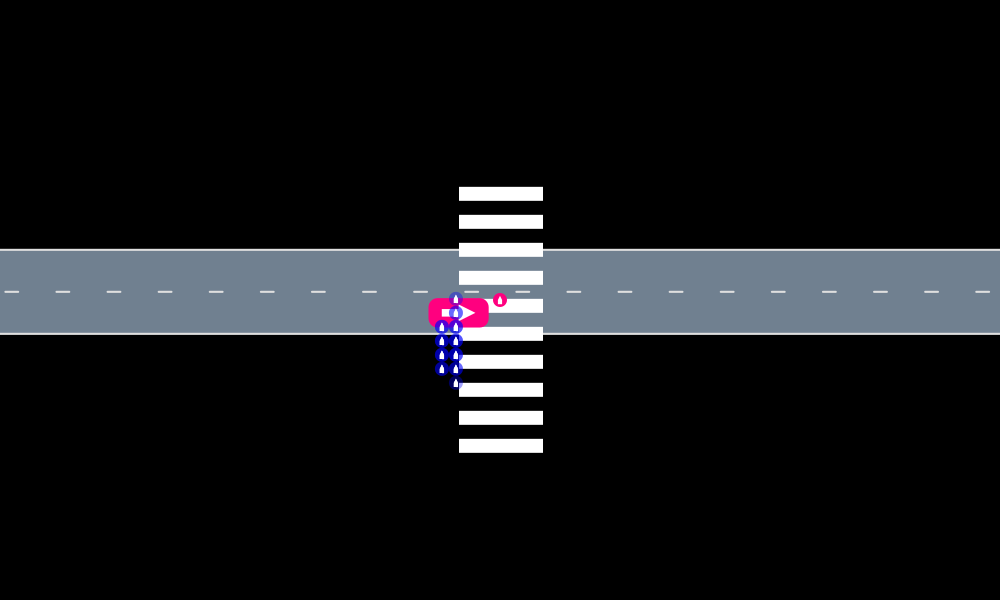

In [19]:
i = 2
scene = rec[0]
bel = belief[i]
belief_overlay = BeliefOverlay(belief=bel, ego_vehicle=ego_vehicle[i])

AutoViz.render(rec[-1], env, SceneOverlay[belief_overlay], cam=CarFollowCamera(2,14.0))

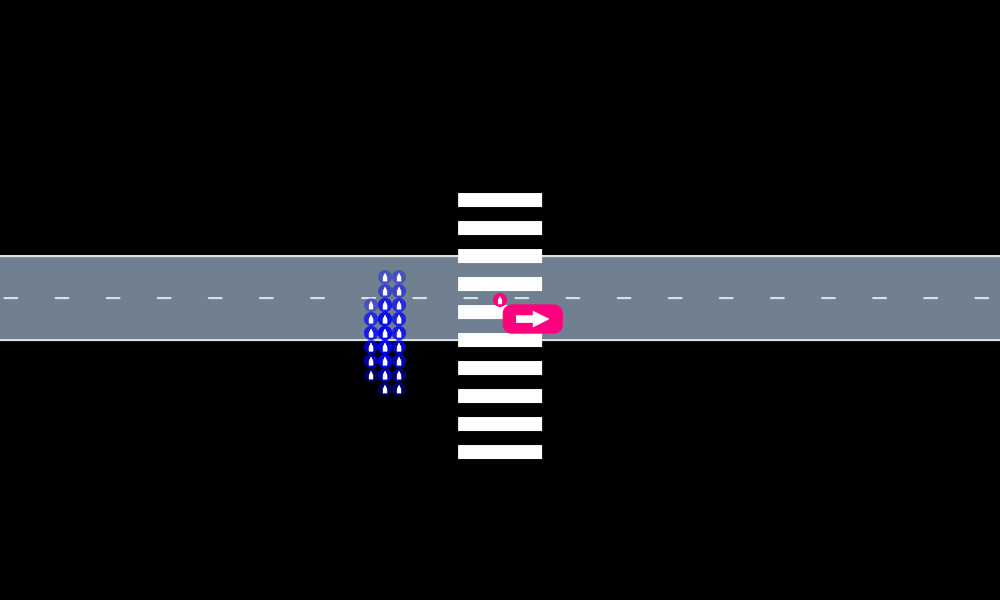

In [20]:
include("../src/pedestrian_crossing/pomdp_types.jl")
include("../src/pedestrian_crossing/spaces.jl")
include("../src/pedestrian_crossing/transition.jl")
include("../src/pedestrian_crossing/observation.jl")
include("../src/pedestrian_crossing/belief.jl")

include("../src/pedestrian_crossing/frenet_pedestrian_pomdp.jl")

next_states = SingleOCFState[]
for (s, prob) in weighted_iterator(bel)
    td = transition(pomdp, s, SingleOCFAction(-2.0, 0.0), pomdp.ΔT)
    for sp in td.vals
        push!(next_states, sp)
    end
end
pred_bel = SparseCat(next_states, normalize(ones(length(next_states)),1))
belief_overlay = BeliefOverlay(belief=pred_bel, ego_vehicle=ego_vehicle[i])
fake_ego = VehicleState()
scene = Scene()
AutoViz.render(rec[0], env, SceneOverlay[belief_overlay], cam=CarFollowCamera(2,14.0))